In [1]:
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
station = "Bats"

In [18]:
data = xr.load_dataset(f"./products/{station}_obs.zarr", engine="zarr")
grouped_data = data.groupby("time.dayofyear").mean()
grouped_data

<xarray.Dataset> Size: 6kB
Dimensions:    (dayofyear: 251, latitude: 1, longitude: 1, layer: 1)
Coordinates:
  * latitude   (latitude) float64 8B 31.6
  * layer      (layer) int64 8B 0
  * longitude  (longitude) float64 8B -64.2
  * dayofyear  (dayofyear) int64 2kB 6 7 11 12 13 14 ... 345 346 347 348 349 350
Data variables:
    day        (dayofyear, latitude, longitude, layer) float64 2kB nan ... 0.96
    night      (dayofyear, latitude, longitude, layer) float64 2kB 2.01 ... nan
Attributes:
    creation date:  2024-10-13T20:03:40.209673
    layer:          epipelagic
    station:        Bats

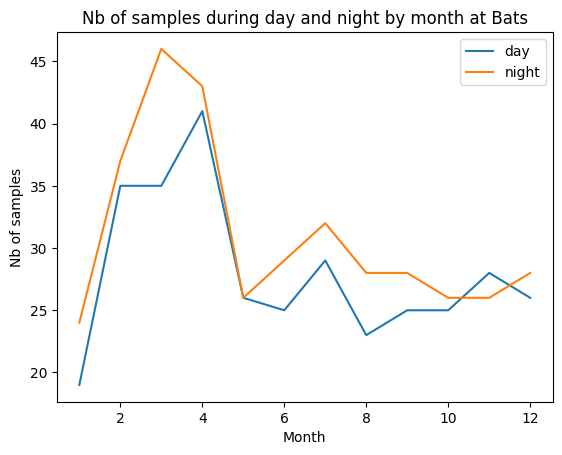

In [17]:
data.groupby("time.month").count().day[:, 0, 0, 0].plot(label="day")
data.groupby("time.month").count().night[:, 0, 0, 0].plot(label="night")
plt.legend()
plt.title(f"Nb of samples during day and night by month at {station}")
plt.xlabel("Month")
plt.ylabel("Nb of samples")
plt.show()

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/accessor_dt.py:453: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/accessor_dt.py:453: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


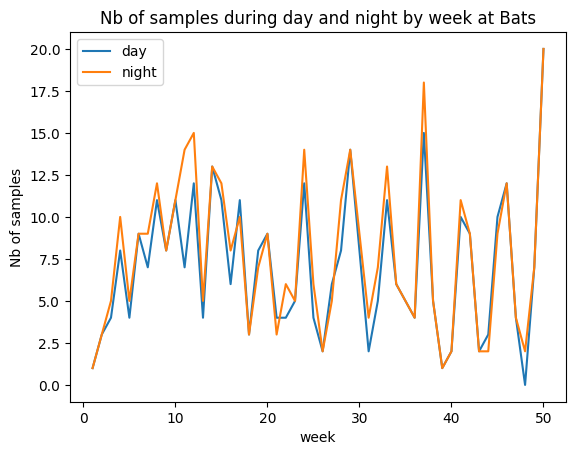

In [16]:
data.groupby("time.week").count().day[:, 0, 0, 0].plot(label="day")
data.groupby("time.week").count().night[:, 0, 0, 0].plot(label="night")
plt.legend()
plt.title(f"Nb of samples during day and night by week at {station}")
plt.xlabel("week")
plt.ylabel("Nb of samples")
plt.show()

Smooth 7 days window


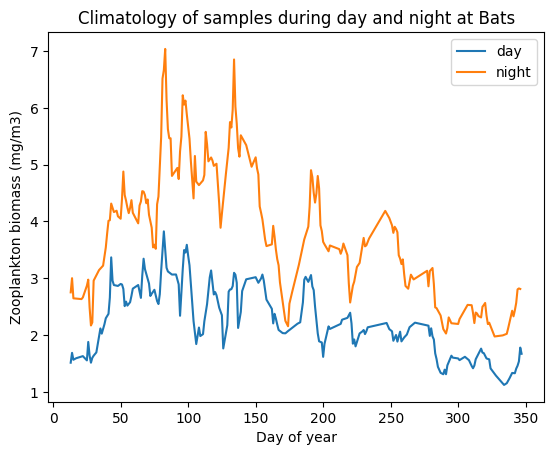

In [22]:
grouped_data.day.dropna("dayofyear").rolling(dayofyear=7, center=True).mean().plot(label="day")
grouped_data.night.dropna("dayofyear").rolling(dayofyear=7, center=True).mean().plot(label="night")
plt.legend()
plt.title(f"Climatology of samples during day and night at {station}")
plt.xlabel("Day of year")
plt.ylabel("Zooplankton biomass (mg/m3)")
plt.show()

Smooth 14 days window


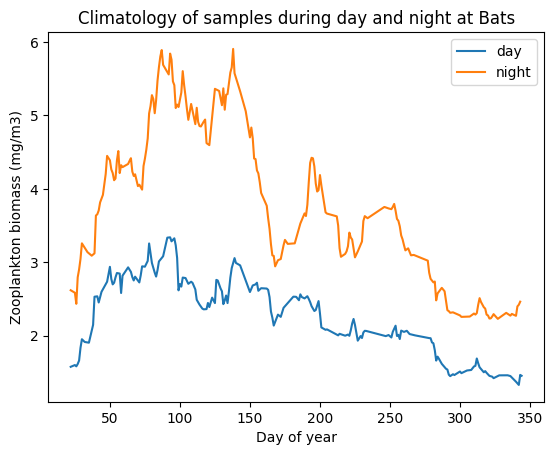

In [23]:
grouped_data.day.dropna("dayofyear").rolling(dayofyear=14, center=True).mean().plot(label="day")
grouped_data.night.dropna("dayofyear").rolling(dayofyear=14, center=True).mean().plot(label="night")
plt.legend()
plt.title(f"Climatology of samples during day and night at {station}")
plt.xlabel("Day of year")
plt.ylabel("Zooplankton biomass (mg/m3)")
plt.show()